# Bayesian modeling of Grid'5000 clusters

In [ ]:
csv_url = 'https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/stats.csv'
changelog_url = 'https://gitlab.in2p3.fr/tom.cornebize/g5k_data/raw/master/exp_changelog.csv'
cluster = 'dahu'
factor = 'avg_gflops'

In [2]:
%load_ext autoreload
%autoreload 2
import requests
import pandas
import io
import datetime
import plotnine
plotnine.options.figure_size = (12, 8)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from plotnine import *

In [3]:
import non_regression_tests as nrt

df = nrt.format(nrt.get(csv_url))

2020-03-10 18:44:13,109 - non_regression_tests - INFO - Downloaded a dataframe with 51243 rows and 26 columns


In [4]:
df = nrt.filter(df, cluster=cluster)

2020-03-10 18:44:13,141 - non_regression_tests - INFO - Filtered the dataframe, there remains 7600 rows


In [5]:
changelog = nrt.format_changelog(nrt.get(changelog_url))

2020-03-10 18:44:13,504 - non_regression_tests - INFO - Downloaded a dataframe with 4 rows and 5 columns


In [6]:
df = df[df['timestamp'] > changelog['date'].max()]
df['timestamp'].min()

Timestamp('2019-11-27 09:58:40')

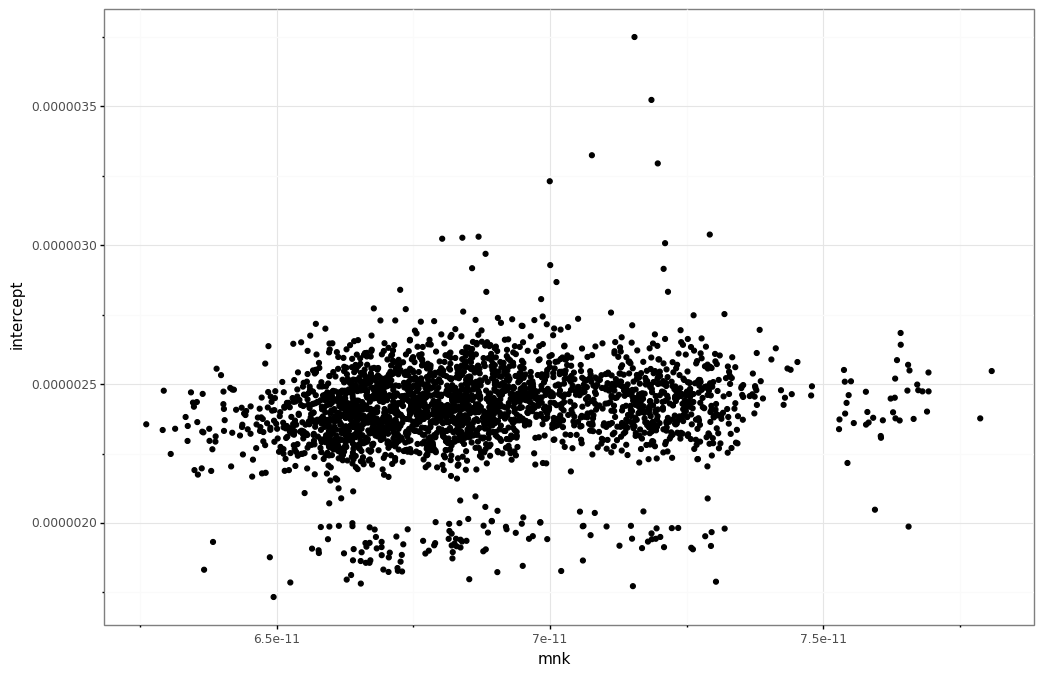

<ggplot: (-9223363283104839487)>

In [7]:
ggplot(df) +\
    aes(x='mnk', y='intercept') +\
    geom_point() +\
    theme_bw()

In [8]:
import pystan
import numpy

In [9]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    int<lower=1> nb_nodes;
    matrix[nb_nodes,N] mnk;
    matrix[nb_nodes,N] intercept;
    matrix[nb_nodes,N] mnk_sd;

    real<lower=0> prior_alpha;
    real<lower=0> prior_beta;
    real<lower=0> prior_sigma;
    real<lower=0> prior_delta;
    real<lower=0> prior_gamma;
}
parameters {
    real<lower=0> hyper_alpha_raw;
    real<lower=0> hyper_beta_raw;
    real<lower=0> hyper_gamma_raw;
    real<lower=0> sigma_raw;
    real<lower=0> delta_raw;

    vector<lower=0>[nb_nodes] alpha_raw;
    vector<lower=0>[nb_nodes]  beta_raw;
    vector<lower=0>[nb_nodes] gamma_raw;
}
transformed parameters {
    real<lower=0> hyper_alpha;
    real<lower=0>  hyper_beta;
    real<lower=0> hyper_gamma;
    real<lower=0>  sigma;
    real<lower=0>  delta;

    vector<lower=0>[nb_nodes] alpha;
    vector<lower=0>[nb_nodes]  beta;
    vector<lower=0>[nb_nodes] gamma;

    // Priors (defined as N(mu, mu))
    hyper_alpha = prior_alpha + hyper_alpha_raw*prior_alpha;
    hyper_beta  = prior_beta  + hyper_beta_raw*prior_beta;
    hyper_gamma = prior_gamma + hyper_gamma_raw*prior_gamma;

    sigma = prior_sigma + sigma_raw*prior_sigma;
    delta = prior_delta + delta_raw*prior_delta;
    for(i in 1:nb_nodes){
       alpha[i] = hyper_alpha+alpha_raw[i]*hyper_alpha;
       beta[i]  = hyper_beta +beta_raw[i] *hyper_beta;
       gamma[i] = hyper_gamma+gamma_raw[i]*hyper_gamma;
    }
}
model {
    // We define our priors
    alpha_raw ~ normal(0, 1);
    beta_raw ~ normal(0, 1);
    gamma_raw ~ normal(0, 1);
    hyper_alpha_raw ~ normal(0, 1);
    hyper_beta_raw ~ normal(0, 1);
    hyper_gamma_raw ~ normal(0, 1);
    sigma_raw ~ normal(0, 1);
    delta_raw ~ normal(0, 1);

    // Then, our likelihood function
    for(i in 1:nb_nodes) {
        alpha[i] ~ normal(hyper_alpha, hyper_alpha*sigma);
        beta[i] ~ normal(hyper_beta, hyper_beta*sigma);
        gamma[i] ~ normal(hyper_gamma, hyper_gamma*sigma);
        mnk[i] ~ normal(alpha[i], alpha[i]*delta);
        intercept[i] ~ normal(beta[i], beta[i]*delta);
        mnk_sd[i] ~ normal(gamma[i], gamma[i]*delta);
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_445081ae97e4555448f66bffa77bba4d NOW.


CPU times: user 921 ms, sys: 47.3 ms, total: 968 ms
Wall time: 50.7 s


In [10]:
min_count = int(df.groupby(['cluster', 'node', 'cpu'])[['expfile_hash']].count().min())
print(f'The least tested node has been tested {min_count} times')

The least tested node has been tested 36 times


In [11]:
data = {
    'N': min_count,
    'nb_nodes': len(df[['node', 'cpu']].drop_duplicates()),
    'mnk': [],
    'intercept': [],
    'mnk_sd': [],
    'prior_alpha': 6.4e-11,
    'prior_beta': 2.3e-6,
    'prior_sigma': 0.03,
    'prior_delta': 0.03,
    'prior_gamma': 3e-13,
}

for _, row in df[['node', 'cpu']].drop_duplicates().iterrows():
    tmp = df[(df['node'] == row.node) & (df['cpu'] == row.cpu)]
    tmp = tmp.tail(n=min_count)
    data['mnk'].append(list(tmp['mnk']))
    data['intercept'].append(list(tmp['intercept']))
    data['mnk_sd'].append(list(tmp['mnk_residual']))

for col in ['mnk', 'intercept', 'mnk_sd']:
    data[col] = numpy.matrix(data[col])

## Maximum likelihood

In [12]:
pandas.DataFrame(sm.optimizing(data=data))[['hyper_alpha', 'hyper_beta', 'hyper_gamma', 'sigma', 'delta']].drop_duplicates()

,hyper_alpha,hyper_beta,hyper_gamma,sigma,delta
0,6.400004e-11,0.000002,5.220973e-13,0.179368,0.096077


## Sampling

CPU times: user 1.7 s, sys: 63.3 ms, total: 1.76 s
Wall time: 13.5 s


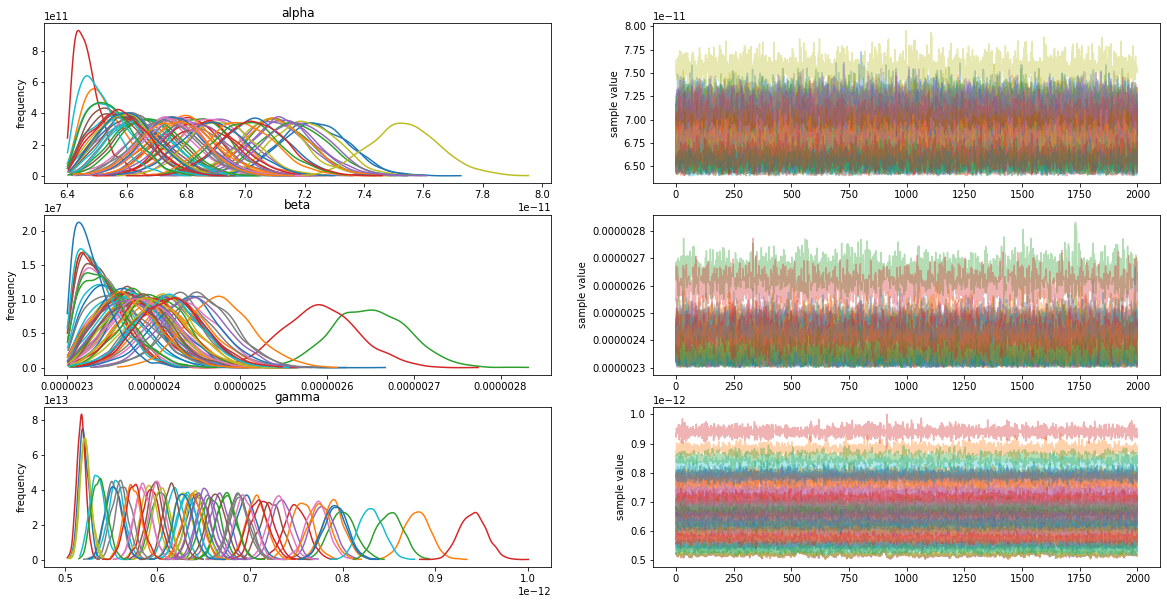

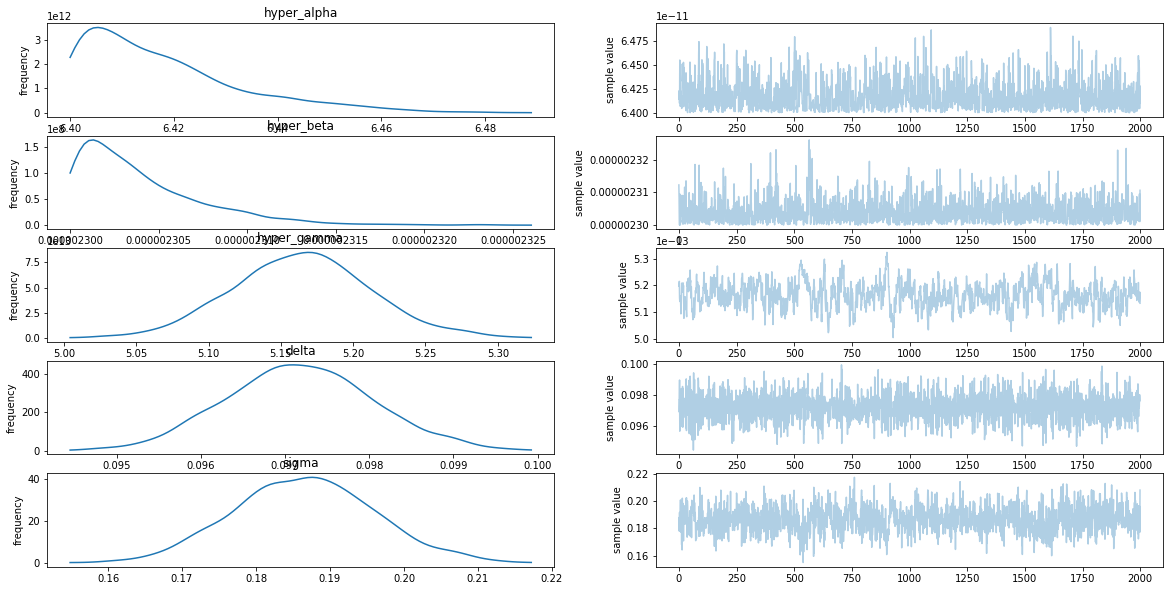

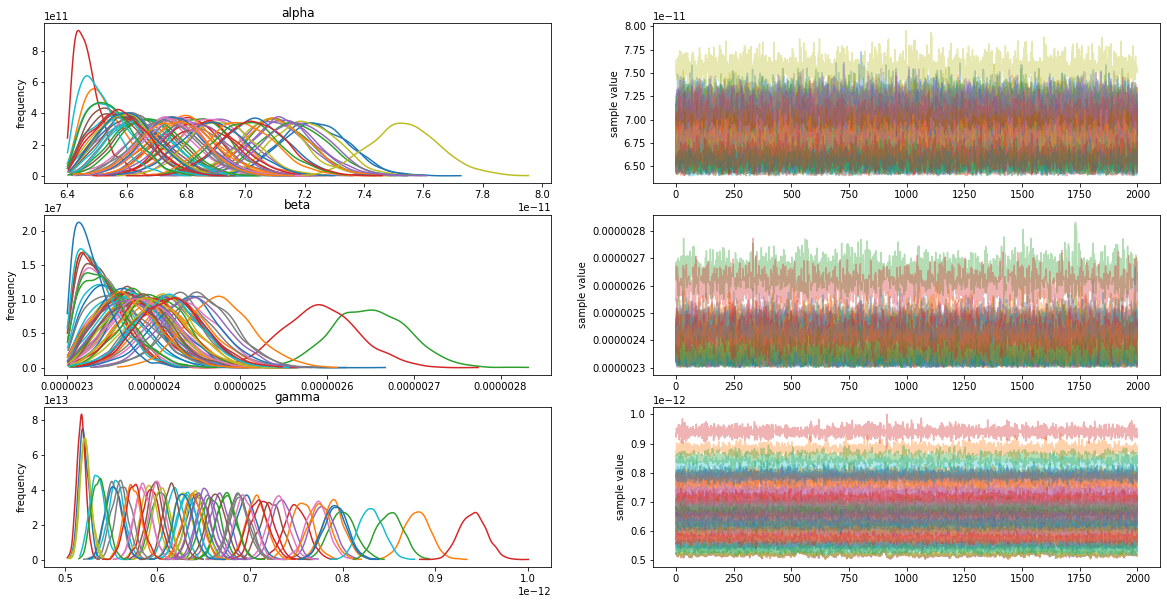

In [13]:
%%time

fit = sm.sampling(data=data, iter=500, chains=8)

fit.plot(['hyper_alpha', 'hyper_beta', 'hyper_gamma', 'delta', 'sigma'])
fit.plot(['alpha', 'beta', 'gamma'])

In [14]:
numpy.mean(fit.extract('hyper_gamma')['hyper_gamma'])

5.164230703275916e-13

In [15]:
def generate_real(fit, i):
    fit = fit.extract()
    model = []
    nb_nodes = len(fit['alpha'][i])
    for node in range(nb_nodes):
        reg = {}
        reg['intercept'] = fit['beta'][i][node]
        reg['mnk'] = fit['alpha'][i][node]
        reg['mnk_residual'] = fit['gamma'][i][node]
        reg['node'] = node
        model.append(reg)
    return model

In [16]:
def generate_synthetic(fit, i, nb_nodes):
    fit = fit.extract()
    model = []
    cols = ['alpha', 'beta', 'gamma']
    params = {c:fit[f'hyper_{c}'][i] for c in cols}
    sigma = fit['sigma'][i]
    delta = fit['delta'][i]
    params_p = {}
    for name, val in params.items():
        params_p[name] = numpy.random.normal(params[name], params[name]*sigma, nb_nodes)
    for node in range(nb_nodes):
        reg = {}
        tmp = {}
        for name, val in params_p.items():
            tmp[name] = numpy.random.normal(params_p[name][node], params_p[name][node]*delta, 1)[0]
        reg['intercept'] = tmp['beta']
        reg['mnk'] = tmp['alpha']
        reg['mnk_residual'] = tmp['gamma']
        reg['node'] = node
        model.append(reg)
    return model

In [17]:
def annotate_model(model, comment=None):
    total_mnk = 0
    total_intercept = 0
    nb_nodes = len(model)
    for i, reg in enumerate(model):
        reg = dict(reg)
        reg['avg_gflops'] = 2e-9/reg['mnk']
        total_mnk += reg['mnk']
        total_intercept += reg['intercept']
        for key, val in reg.items():
            if key != 'node':
                reg[key] = float(val)
        model[i] = reg
    result = {'model': model}
    result['info'] = {
        'avg_gflops': nb_nodes*2e-9/total_mnk,
        'avg_mnk': total_mnk/nb_nodes,
        'avg_intercept': total_intercept/nb_nodes,
        'nb_nodes': nb_nodes,
    }
    result['metadata'] = {
        'file_creation_date': str(datetime.datetime.now()),
        'granularity': 'node',
    }
    if comment:
        result['metadata']['comment'] = comment
    return result

In [18]:
print(annotate_model(generate_real(fit, 18))['info'])
print(annotate_model(generate_synthetic(fit, 18, 1000))['info'])

{'avg_gflops': 29.376257273411092, 'avg_mnk': 6.808219241088385e-11, 'avg_intercept': 2.3914068043163937e-06, 'nb_nodes': 64}
{'avg_gflops': 31.36031173442998, 'avg_mnk': 6.377487624921255e-11, 'avg_intercept': 2.2745919121570836e-06, 'nb_nodes': 1000}
